In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
import imageio.v2 as imageio
import os
from IPython.display import Image, display
from matplotlib.patches import Circle
import base64
from io import BytesIO
import pymunk


In [2]:
def run_simulation(initial_state, steps=100, env_size=600):
    # Create the physics space
    space = pymunk.Space()
    space.gravity = (0, -981)  # Set gravity

    # Define boundaries (e.g., a 600x600 box)
    walls = [
        pymunk.Segment(space.static_body, (0, 0), (env_size, 0), 1),
        pymunk.Segment(space.static_body, (env_size, 0), (env_size, env_size), 1),
        pymunk.Segment(space.static_body, (env_size, 600), (0, env_size), 1),
        pymunk.Segment(space.static_body, (0, env_size), (0, 0), 1)
    ]
    for wall in walls:
        wall.elasticity = 0.95  # Coefficient of elasticity for the walls
        space.add(wall)

    # Create objects based on initial state
    objects = {}
    for obj_id, attrs in initial_state.items():
        mass = attrs['mass']
        radius = attrs['radius']
        inertia = pymunk.moment_for_circle(mass, 0, radius)
        body = pymunk.Body(mass, inertia)
        body.position = attrs['location']
        body.velocity = attrs['velocity']
        shape = pymunk.Circle(body, radius)
        shape.elasticity = 0.8  # Adjust elasticity as needed
        space.add(body, shape)
        objects[obj_id] = {'body': body, 'shape': shape}

    # Simulation steps
    timeline = []
    for i in range(steps):
        space.step(1/50.0)  # Advance the simulation
        step_state = {
            'time': i,
            'objects': {}
        }
        # Record the state for each object
        for obj_id, obj in objects.items():
            step_state['objects'][obj_id] = {
                'location': (obj['body'].position.x, obj['body'].position.y),
                'velocity': (obj['body'].velocity.x, obj['body'].velocity.y),
                'radius': obj['shape'].radius,
                'mass': obj['shape'].mass
            }
        timeline.append(step_state)

    return timeline

In [3]:
def generate_initial_state(n_objects, env_size, radius_range, mass_range):
    initial_state = {}
    for i in range(n_objects):
        # Generate random mass and radius within the specified range
        mass = random.uniform(mass_range[0], mass_range[1])
        radius = random.uniform(radius_range[0], radius_range[1])
        
        # Generate a random location within the environment bounds
        location = (random.uniform(radius, env_size - radius), 
                    random.uniform(radius, env_size - radius))
        
        # Initial velocity can be set to zero or randomized if needed
        velocity = (0, 0)  # Set as zero for simplicity, can be randomized
        
        # Store the object's attributes
        initial_state[str(i)] = {
            'mass': mass,
            'radius': radius,
            'location': location,
            'velocity': velocity
        }
    
    return initial_state

In [4]:
def simulation_to_gif(data, env_size, filename='simulation.gif', skip_frames=1):
    # Create a folder to store images temporarily
    if not os.path.exists('frames'):
        os.makedirs('frames')
    
    # Plot each frame and save as an image
    images = []
    for index, step in enumerate(data[::skip_frames]):
        fig, ax = plt.subplots()
        ax.set_xlim(0, env_size)  # Set these limits to the size of your simulation space
        ax.set_ylim(0, env_size)
        ax.set_aspect('equal')  # Ensures that circle remains circular

        # Plot each object with a Circle patch
        for obj_id, obj in step['objects'].items():
            circle = Circle((obj['location'][0], obj['location'][1]), obj['radius'], color='blue')
            ax.add_patch(circle)
        
        ax.set_title(f'Time = {step["time"]}')
        
        # Save each plot as an image file
        frame_filename = f'frames/frame_{index:04d}.png'
        plt.savefig(frame_filename)
        plt.close(fig)
        images.append(imageio.imread(frame_filename))
    
    # Create GIF with loop=0 for infinite loop
    imageio.mimsave(filename, images, duration=0.1, loop=0)
    
    # Clean up frames
    for frame_filename in os.listdir('frames'):
        os.remove(f'frames/{frame_filename}')
    os.rmdir('frames')

    # Display the GIF in the notebook as a base64 image
    with open(filename, 'rb') as f:
        image_data = f.read()
        b64 = base64.b64encode(image_data).decode('utf-8')
        display(Image(url=f"data:image/gif;base64,{b64}"))

In [5]:
# Example usage:
n_objects = 10
env_size = 600
radius_range = (5, 25)  # Radius range
mass_range = (0.1, 5)  # Mass range
initial_state = generate_initial_state(n_objects, env_size, radius_range, mass_range)

In [6]:
simulation_data = run_simulation(initial_state, steps=100, env_size=env_size)


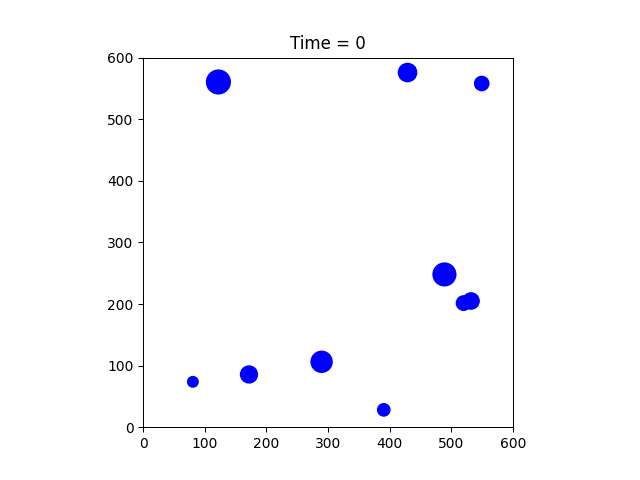

In [7]:
simulation_to_gif(simulation_data, env_size=env_size)